In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from optvis import visualize_feature

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = cnn_learner(data, models.resnet50)

In [4]:
m = learn.model.eval()

In [8]:
def init_fft_buf(size):
    img_buf = np.random.normal(size=(1, 3, size, size//2 + 1,2), scale=0.01).astype(np.float32)
    spectrum_t = tensor(img_buf).float()
    return spectrum_t
    
def fft_to_rgb(t):
    size = t.shape[-3]

    fy = np.fft.fftfreq(size)[:,None]
    fx = np.fft.fftfreq(size)[: size//2 + 1]
    freqs = (np.sqrt(fx * fx + fy * fy))
    scale = 1.0 / np.maximum(freqs, 1.0 / max(size, size)) ** 1
    scale = tensor(scale).float()[None,None,...,None]
    t = scale * t

    image_t = torch.irfft(t,2,signal_sizes=(size,size), normalized=True)
    image_t = image_t / 4.0

    return image_t

def init_pixel_buf(size):
    img_buf = torch.empty(1,3,size,size).normal_(mean=0,std=0.01)
    img_buf = torch.sigmoid(tensor(img_buf))
    return img_buf
    
def lucid_to_rgb(t):
    color_correlation_svd_sqrt = np.asarray([[0.26, 0.09, 0.02],
                                             [0.27, 0.00, -0.05],
                                             [0.27, -0.09, 0.03]]).astype(np.float32)
    max_norm_svd_sqrt = np.max(np.linalg.norm(color_correlation_svd_sqrt, axis=0))

    t_flat = t.permute(0,2,3,1)
    color_correlation_normalized = tensor(color_correlation_svd_sqrt / max_norm_svd_sqrt)
    t_flat = torch.matmul(t_flat, color_correlation_normalized.T)
    t = t_flat.permute(0,3,1,2)
    return t

def show_image_buf(img_buf, jitter, label=None, decorrelate=True, fft=True):
    img = img_buf.detach()
    if fft: img=fft_to_rgb(img)
    size = img.shape[-1]
    x_off,y_off = jitter//2,jitter//2
    if decorrelate: img = lucid_to_rgb(img)
    img = torch.sigmoid(img)
    img = img[:,:,x_off:x_off+size-jitter,y_off:y_off+size-jitter] # jitter
    img = Image(img[0])
    img.show(figsize=(img.shape[1]/25,img.shape[2]/25))
    plt.title(label)
    plt.show()

def visualize_feature(model, layer, feature,
                      size=200, jitter=25,
                      steps=2000, lr=0.05,
                      decorrelate=True, fft=True,
                      debug=False):
    img_buf = init_fft_buf(size+jitter) if fft else init_pixel_buf(size+jitter)
    img_buf.requires_grad_()
    opt = torch.optim.Adam([img_buf], lr=lr)

    with hook_output(layer,detach=False) as hook_a:
        for i in range(steps):
            x_off, y_off = int(np.random.random()*jitter),int(np.random.random()*jitter)
            img = fft_to_rgb(img_buf) if fft else img_buf
            img = img[:,:,x_off:x_off+size+1,y_off:y_off+size+1] # jitter
            if decorrelate: img = lucid_to_rgb(img) # decorrelate color
            model(img.cuda())
            opt.zero_grad()
            loss = -1*hook_a.stored[0][feature].mean()
            loss.backward()
            opt.step()
            if debug and i%(steps/10)==0: 
                show_image_buf(img_buf, jitter, label=f"step: {i} loss: {loss}", decorrelate=decorrelate, fft=fft)

    show_image_buf(img_buf, jitter, label=f"Feature {feature}",decorrelate=decorrelate, fft=fft)

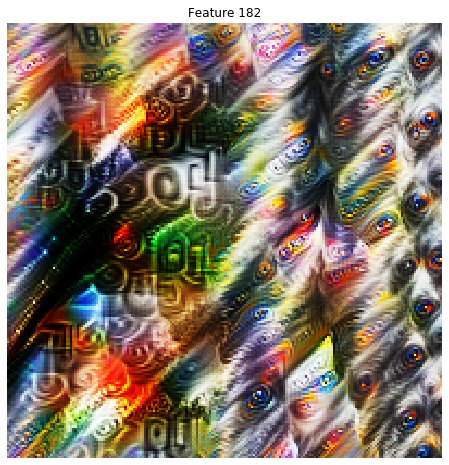

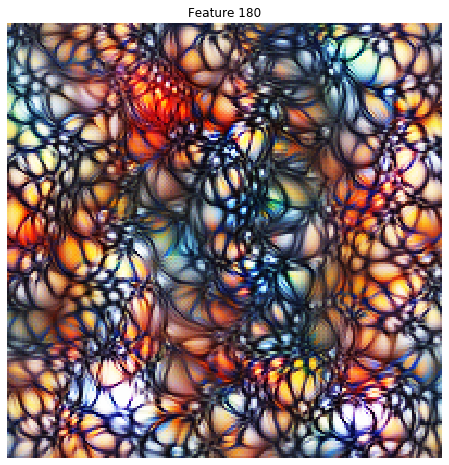

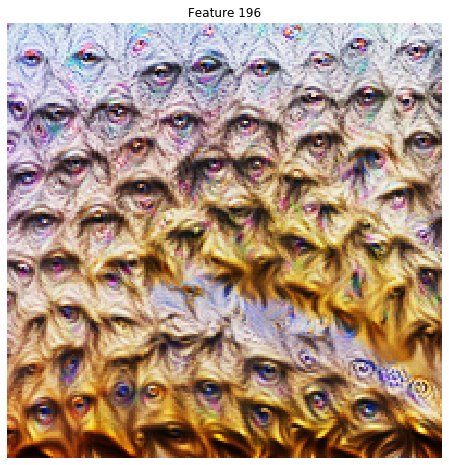

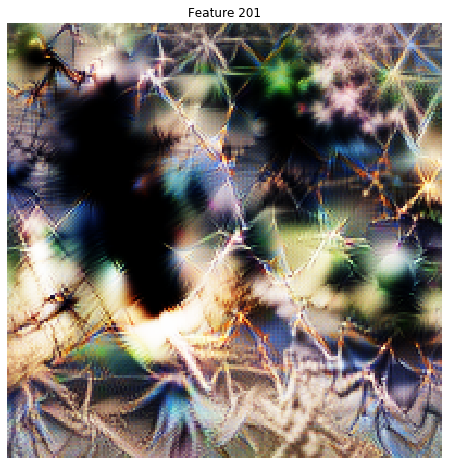

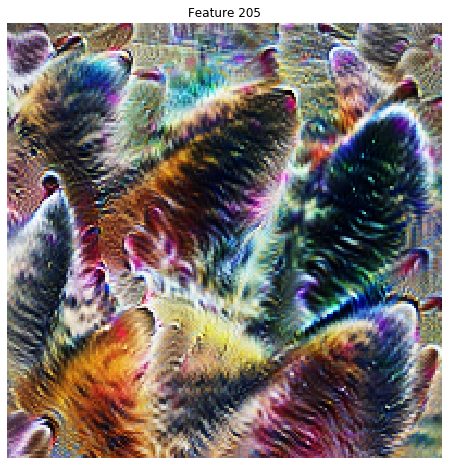

In [5]:
for feature in [182, 180, 196, 201, 205]:
    visualize_feature(m, m[0][6][5], feature, steps=500, lr=0.05, decorrelate=True, fft=True, debug=False)    